In [28]:
import baltic as bt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import linregress
%matplotlib inline

In [29]:
titer_file = '../data/titers_katzelnick2015/normalized_titers.csv'
aa_dist_file = '../data/sequences/titered_strains_aa_dist.csv'

colors = pickle.load(open('../figures/colors.p', 'rb'))
out_path = './png/'

In [42]:
genetic_distances = {(l.split(',')[1],l.split(',')[2].strip()): float(l.split(',')[0]) for l in open(aa_dist_file, 'r')}
genetic_distances.update({ (k[1],k[0] ) : v for k,v in genetic_distances.items() })

In [43]:
titers = pd.read_csv(titer_file, sep=',', index_col=None)

In [44]:
genetic_distances.items()[0]

(('DENV2/CAMBODIA/BIDV3924/2008', 'DENV4/THAILAND/D85052/1985'), 179.0)

In [46]:
distances = []
for idx,entry in titers.iterrows():
    strains = tuple([entry['virus'], entry['serum']])
    if strains[0] == strains[1]:
        genetic = 0.
        homotypic = True
    else:
        genetic = genetic_distances[strains]
        homotypic = strains[0].split('/')[0] == strains[1].split('/')[0]
        
    distances.append({'strains': strains,
    'homotypic': homotypic,
    'genetic': genetic,
    'titer': entry['titer']})
distances = pd.DataFrame(distances)

In [47]:
distances.head()

,genetic,homotypic,strains,titer
0,0.0,True,"(DENV1/BOLIVIA/FSB3363/2010, DENV1/BOLIVIA/FSB...",0.000000
1,13.0,True,"(DENV1/BOLIVIA/FSB3363/2010, DENV1/CAMBODIA/BI...",1.494765
2,15.0,True,"(DENV1/BOLIVIA/FSB3363/2010, DENV1/MYANMAR/611...",1.782562
3,11.0,True,"(DENV1/BOLIVIA/FSB3363/2010, DENV1/NAURU/WESTE...",0.058894
4,3.0,True,"(DENV1/BOLIVIA/FSB3363/2010, DENV1/PERU/IQT615...",2.459432


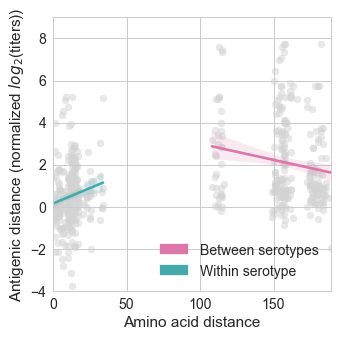

In [48]:
sns.set(style='whitegrid', font_scale=1.4)
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(distances['genetic'].min()-.05, distances['genetic'].max()+.05)
ax.set_ylim(distances['titer'].min()-.05, distances['titer'].max()+.05)
homotypic = distances.loc[distances['homotypic'] == True]
heterotypic = distances.loc[distances['homotypic'] == False]

sns.regplot(x='genetic', y='titer', data=homotypic, 
            color=colors['all_effects'], ax=ax, scatter=False, truncate=True, n_boot=1000)
fit = linregress(homotypic['genetic'], homotypic['titer'])

sns.regplot(x='genetic', y='titer', data=heterotypic, 
            color=colors['interserotype_effects'], ax=ax, scatter=False, truncate=True, n_boot=1000)
fit = linregress(heterotypic['genetic'], heterotypic['titer'])
# sns.regplot(x='patristic', y='titer', data=distances, 
#            color='lightgray', ax=ax, scatter=False, truncate=True)

ax.scatter(distances['genetic'], distances['titer'], alpha=0.5, c='lightgray', zorder=0)

# ax.scatter(homotypic['patristic'], homotypic['titer'], alpha=0.4, c='lightgray', zorder=0)
# ax.scatter(heterotypic['patristic'], heterotypic['titer'], alpha=0.4, c='lightgray', zorder=0)

ax.set_xlabel('Amino acid distance')
ax.set_ylabel(r'Antigenic distance (normalized $log_2$(titers))')
interserotype_label = mpatches.Patch(color=colors['interserotype_effects'], label='Between serotypes')
intraserotype_label = mpatches.Patch(color=colors['all_effects'], label='Within serotype')

ax.set_ylim(-4,9)
plt.legend(handles=[interserotype_label, intraserotype_label])
plt.tight_layout()
# plt.savefig('./png/genetic_antigenic_distance.png', dpi=300, bbox_inches='tight')

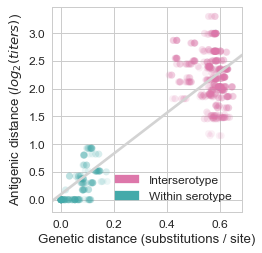

In [4]:
def plot_geno_pheno(df, ax):
    c = [ colors['all_effects'] if i==True else colors['interserotype_effects'] for i in df['homotypic'].values]
    sns.regplot('genetic', 'antigenic', data=df, 
                scatter_kws={'color': c, 'alpha': 0.1}, 
                line_kws={'color': 'lightgray'},
                ax=ax)
    ax.set_xlabel('Genetic distance (substitutions / site)')
    ax.set_ylabel('Antigenic distance ('+r'$log_2(titers)$'+')')

sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(7.5/2,7.5/2))

try:
    plot_geno_pheno(distances, ax)
except:
    print 'Oops. First calculate distances (see last cell)'
    
interserotype_label = mpatches.Patch(color=colors['interserotype_effects'], label='Interserotype')
intraserotype_label = mpatches.Patch(color=colors['all_effects'], label='Within serotype')
plt.legend(handles=[interserotype_label, intraserotype_label])

plt.tight_layout()
plt.savefig('./png/genetic_antigenic_distance.png', dpi=300, bbox_inches='tight')
plt.show()